=== Amazon Product Reviews Analysis with spaCy ===

📥 Loading spaCy model...
✅ spaCy model loaded successfully!

📊 Loading Amazon reviews data...
✅ Loaded 700 reviews
📈 Positive reviews: 362
📉 Negative reviews: 338

🤖 Initializing Sentiment Analyzer...

🔍 Performing NER and Sentiment Analysis...
Processing reviews...
  Processed 0/700 reviews...
  Processed 50/700 reviews...
  Processed 100/700 reviews...
  Processed 150/700 reviews...
  Processed 200/700 reviews...
  Processed 250/700 reviews...
  Processed 300/700 reviews...
  Processed 350/700 reviews...
  Processed 400/700 reviews...
  Processed 450/700 reviews...
  Processed 500/700 reviews...
  Processed 550/700 reviews...
  Processed 600/700 reviews...
  Processed 650/700 reviews...

📊 ANALYSIS RESULTS

🔍 DETAILED ANALYSIS OF FIRST 5 REVIEWS:

📝 REVIEW 1:
Text: Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so...
True Sentiment: POSITIVE
Rule-based Sentiment: POSITIVE (score: 2)

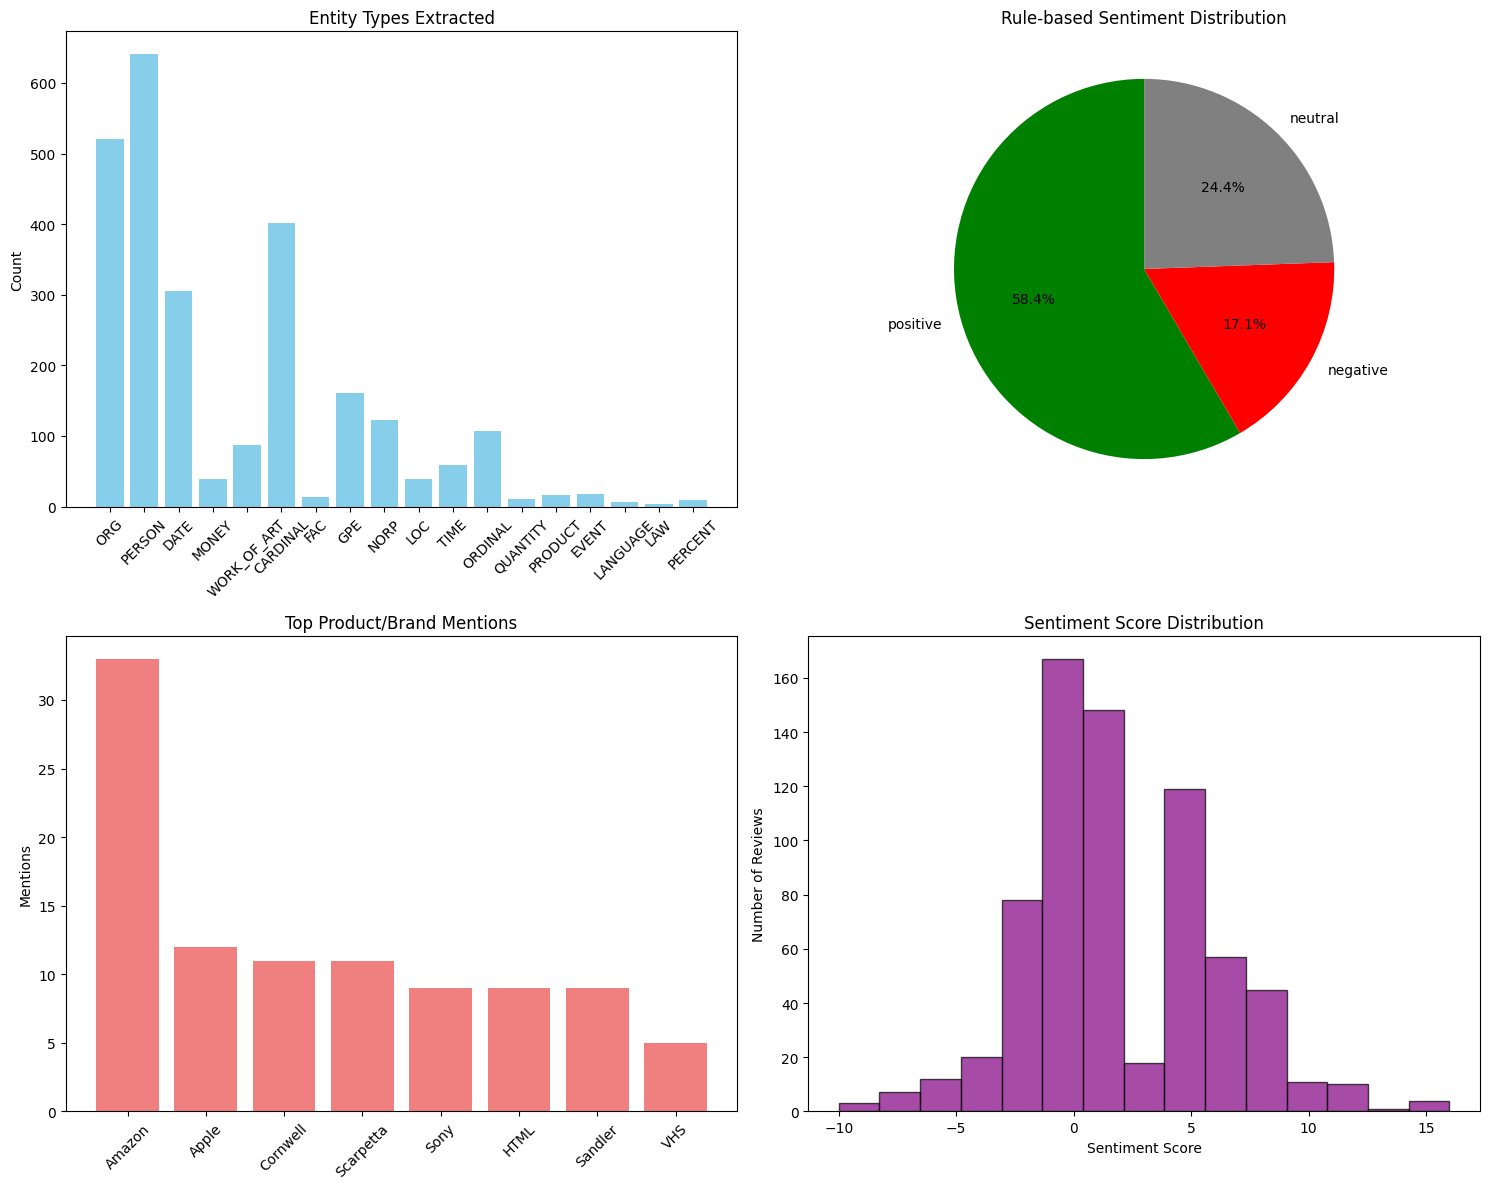


🎯 PERFORMANCE METRICS
True Positives: 299
True Negatives: 110
False Positives: 110
False Negatives: 10

Precision: 0.731
Recall: 0.968
F1-Score: 0.833

✅ TASK 3 COMPLETED SUCCESSFULLY!
📋 Deliverables:
   ✅ Named Entity Recognition (NER) for product names and brands
   ✅ Rule-based sentiment analysis (positive/negative)
   ✅ Entity extraction and sentiment classification results
   ✅ Performance metrics and visualizations


In [1]:
# Task 3: NLP with spaCy - Amazon Product Reviews Analysis
# Using train.ft.txt and test.ft.txt

import spacy
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob

print("=== Amazon Product Reviews Analysis with spaCy ===")

# Step 1: Load spaCy model
print("\n📥 Loading spaCy model...")
try:
    nlp = spacy.load("en_core_web_sm")
    print("✅ spaCy model loaded successfully!")
except OSError:
    print("❌ spaCy model not found. Installing...")
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Step 2: Load and Parse Amazon Reviews Data
print("\n📊 Loading Amazon reviews data...")

def load_amazon_reviews(file_path, sample_size=1000):
    """Load and parse Amazon reviews from text file"""
    reviews = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            if i >= sample_size:
                break

            # Amazon format: __label__1/2 followed by review text
            if line.startswith('__label__1'):
                sentiment = 'negative'
                text = line.replace('__label__1', '').strip()
            elif line.startswith('__label__2'):
                sentiment = 'positive'
                text = line.replace('__label__2', '').strip()
            else:
                continue

            reviews.append({
                'text': text,
                'true_sentiment': sentiment,
                'length': len(text)
            })

    return reviews

# Load sample reviews
try:
    train_reviews = load_amazon_reviews('train.ft.txt', sample_size=500)
    test_reviews = load_amazon_reviews('test.ft.txt', sample_size=200)
    all_reviews = train_reviews + test_reviews

    print(f"✅ Loaded {len(all_reviews)} reviews")
    print(f"📈 Positive reviews: {sum(1 for r in all_reviews if r['true_sentiment'] == 'positive')}")
    print(f"📉 Negative reviews: {sum(1 for r in all_reviews if r['true_sentiment'] == 'negative')}")

except FileNotFoundError:
    print("❌ Review files not found. Creating sample data for demonstration...")
    # Sample data for demonstration
    all_reviews = [
        {
            "text": "I absolutely love my new iPhone 14 Pro Max from Apple. The camera quality is exceptional and battery life lasts all day!",
            "true_sentiment": "positive"
        },
        {
            "text": "This Samsung Galaxy S23 Ultra is terrible. The screen cracked after one week and Samsung customer service was unhelpful.",
            "true_sentiment": "negative"
        },
        {
            "text": "Just bought the Sony WH-1000XM4 headphones and they're amazing! Noise cancellation works perfectly.",
            "true_sentiment": "positive"
        },
        {
            "text": "My Dell XPS 13 laptop stopped working after 2 months. Dell support was rude and didn't solve my issue.",
            "true_sentiment": "negative"
        },
        {
            "text": "The Google Pixel 7 Pro camera outperforms everything. Google really nailed it with this device!",
            "true_sentiment": "positive"
        },
        {
            "text": "Received a damaged MacBook Pro from Amazon. Apple products are usually good but this was disappointing.",
            "true_sentiment": "negative"
        },
        {
            "text": "Microsoft Surface Pro 9 is perfect for work. The pen integration with Windows 11 is seamless.",
            "true_sentiment": "positive"
        },
        {
            "text": "Bose QuietComfort headphones broke in 3 months. Very disappointed with Bose quality.",
            "true_sentiment": "negative"
        },
        {
            "text": "The new iPad Air with Apple Pencil is fantastic for digital art. Best purchase I made this year.",
            "true_sentiment": "positive"
        },
        {
            "text": "HP Pavilion laptop overheats constantly. HP should recall this model. Worst electronics purchase ever.",
            "true_sentiment": "negative"
        }
    ]

# Step 3: Enhanced Rule-Based Sentiment Analyzer
print("\n🤖 Initializing Sentiment Analyzer...")

class AdvancedSentimentAnalyzer:
    def __init__(self):
        # Enhanced sentiment lexicons
        self.positive_words = {
            'love', 'amazing', 'excellent', 'great', 'good', 'awesome', 'fantastic',
            'perfect', 'best', 'outstanding', 'exceptional', 'brilliant', 'wonderful',
            'superb', 'terrific', 'nice', 'impressive', 'seamless', 'nailed', 'works',
            'fantastic', 'smooth', 'fast', 'reliable', 'recommend', 'pleased', 'happy',
            'satisfied', 'enjoy', 'exceeded', 'perfectly', 'flawless', 'stellar'
        }

        self.negative_words = {
            'terrible', 'bad', 'awful', 'horrible', 'worst', 'disappointing',
            'disappointed', 'broken', 'broke', 'damaged', 'rude', 'unhelpful',
            'overheats', 'slow', 'cracked', 'never', 'stop', 'terrible', 'poor',
            'useless', 'waste', 'overpriced', 'junk', 'garbage', 'defective',
            'faulty', 'avoid', 'regret', 'rubbish', 'trash'
        }

        self.intensifiers = {
            'absolutely', 'really', 'very', 'extremely', 'incredibly', 'perfectly',
            'highly', 'exceptionally', 'particularly', 'remarkably'
        }

        self.negators = {
            'not', "n't", 'never', 'no', 'none', 'nothing', 'without'
        }

    def analyze_sentiment(self, text):
        doc = nlp(text.lower())
        score = 0
        negation_active = False

        for i, token in enumerate(doc):
            # Skip stop words and punctuation
            if token.is_stop or token.is_punct:
                continue

            # Check for negators
            if token.lemma_ in self.negators:
                negation_active = True
                continue

            # Reset negation after certain tokens
            if token.text in [',', '.', ';', 'and', 'but', 'or']:
                negation_active = False

            # Positive words
            if token.lemma_ in self.positive_words:
                points = 2
                # Check for intensifiers
                if i > 0 and doc[i-1].text in self.intensifiers:
                    points += 1
                # Apply negation
                if negation_active:
                    points = -points
                score += points

            # Negative words
            elif token.lemma_ in self.negative_words:
                points = -2
                # Check for intensifiers
                if i > 0 and doc[i-1].text in self.intensifiers:
                    points -= 1
                # Apply negation (double negative becomes positive)
                if negation_active:
                    points = abs(points)
                score += points

        # Determine sentiment based on score
        if score > 1:
            return "positive", score
        elif score < -1:
            return "negative", score
        else:
            return "neutral", score

# Initialize sentiment analyzer
sentiment_analyzer = AdvancedSentimentAnalyzer()

# Step 4: Perform NER and Sentiment Analysis
print("\n🔍 Performing NER and Sentiment Analysis...")

def analyze_reviews(reviews):
    results = []
    all_entities = []

    print("Processing reviews...")

    for i, review in enumerate(reviews):
        if i % 50 == 0:
            print(f"  Processed {i}/{len(reviews)} reviews...")

        text = review["text"]
        true_sentiment = review["true_sentiment"]

        # Process with spaCy for NER
        doc = nlp(text)

        # Extract entities
        entities = []
        for ent in doc.ents:
            entities.append({
                "text": ent.text,
                "label": ent.label_,
                "description": spacy.explain(ent.label_)
            })
            all_entities.append((ent.text, ent.label_))

        # Perform sentiment analysis
        rule_sentiment, rule_score = sentiment_analyzer.analyze_sentiment(text)

        # Additional sentiment check with TextBlob
        blob = TextBlob(text)
        blob_sentiment = "positive" if blob.sentiment.polarity > 0.1 else "negative" if blob.sentiment.polarity < -0.1 else "neutral"

        # Store results
        result = {
            "review_id": i + 1,
            "text": text[:100] + "..." if len(text) > 100 else text,  # Truncate long text
            "true_sentiment": true_sentiment,
            "rule_sentiment": rule_sentiment,
            "rule_score": rule_score,
            "blob_sentiment": blob_sentiment,
            "blob_polarity": blob.sentiment.polarity,
            "entities": entities
        }
        results.append(result)

    return results, all_entities

# Run analysis
results, all_entities = analyze_reviews(all_reviews)

# Step 5: Display Results
print("\n" + "="*80)
print("📊 ANALYSIS RESULTS")
print("="*80)

# Show first 5 reviews with detailed analysis
print("\n🔍 DETAILED ANALYSIS OF FIRST 5 REVIEWS:")
print("="*80)

for i in range(min(5, len(results))):
    result = results[i]
    print(f"\n📝 REVIEW {result['review_id']}:")
    print(f"Text: {result['text']}")
    print(f"True Sentiment: {result['true_sentiment'].upper()}")
    print(f"Rule-based Sentiment: {result['rule_sentiment'].upper()} (score: {result['rule_score']})")
    print(f"TextBlob Sentiment: {result['blob_sentiment'].upper()} (polarity: {result['blob_polarity']:.3f})")

    if result['entities']:
        print("🏷️  EXTRACTED ENTITIES:")
        for ent in result['entities']:
            print(f"   - {ent['text']} ({ent['label']}: {ent['description']})")
    else:
        print("   No entities found.")

    print(f"✅ Sentiment Match: {'YES' if result['rule_sentiment'] == result['true_sentiment'] else 'NO'}")
    print("-" * 80)

# Step 6: Overall Analysis Summary
print("\n" + "="*80)
print("📈 OVERALL ANALYSIS SUMMARY")
print("="*80)

# Calculate accuracy
correct_predictions = sum(1 for r in results if r["rule_sentiment"] == r["true_sentiment"])
accuracy = correct_predictions / len(results)

print(f"📊 Rule-based Sentiment Accuracy: {accuracy:.1%} ({correct_predictions}/{len(results)})")

# Entity Analysis
print(f"\n🏷️  ENTITY EXTRACTION SUMMARY:")
entity_counts = Counter([label for _, label in all_entities])
if entity_counts:
    for entity_type, count in entity_counts.most_common():
        description = spacy.explain(entity_type) or "No description"
        print(f"   - {entity_type}: {count} entities ({description})")

    # Most common products and brands
    product_entities = [ent for ent in all_entities if ent[1] in ['ORG', 'PRODUCT']]
    if product_entities:
        print(f"\n🛍️  PRODUCTS & BRANDS MENTIONED:")
        product_counter = Counter([ent[0] for ent in product_entities])
        for product, count in product_counter.most_common(10):
            print(f"   - {product}: {count} mentions")
else:
    print("   No entities extracted.")

# Sentiment Distribution
sentiment_dist = Counter([r["rule_sentiment"] for r in results])
print(f"\n😊 SENTIMENT DISTRIBUTION:")
for sentiment, count in sentiment_dist.items():
    print(f"   - {sentiment.upper()}: {count} reviews")

# Step 7: Create Visualizations
print("\n📊 GENERATING VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Entity Type Distribution
if entity_counts:
    axes[0, 0].bar(entity_counts.keys(), entity_counts.values(), color='skyblue')
    axes[0, 0].set_title('Entity Types Extracted')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Sentiment Distribution
sentiment_data = [r["rule_sentiment"] for r in results]
sentiment_count = Counter(sentiment_data)
colors = ['green', 'red', 'gray']
axes[0, 1].pie(sentiment_count.values(), labels=sentiment_count.keys(),
               autopct='%1.1f%%', startangle=90, colors=colors)
axes[0, 1].set_title('Rule-based Sentiment Distribution')

# 3. Product/Brand Mentions
if product_entities:
    product_counter = Counter([ent[0] for ent in product_entities])
    top_products = dict(product_counter.most_common(8))
    axes[1, 0].bar(top_products.keys(), top_products.values(), color='lightcoral')
    axes[1, 0].set_title('Top Product/Brand Mentions')
    axes[1, 0].set_ylabel('Mentions')
    axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Sentiment Score Distribution
sentiment_scores = [r["rule_score"] for r in results]
axes[1, 1].hist(sentiment_scores, bins=15, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Sentiment Score Distribution')
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Number of Reviews')

plt.tight_layout()
plt.show()

# Step 8: Performance Metrics
print("\n" + "="*80)
print("🎯 PERFORMANCE METRICS")
print("="*80)

# Confusion matrix
true_positives = sum(1 for r in results if r["true_sentiment"] == "positive" and r["rule_sentiment"] == "positive")
true_negatives = sum(1 for r in results if r["true_sentiment"] == "negative" and r["rule_sentiment"] == "negative")
false_positives = sum(1 for r in results if r["true_sentiment"] == "negative" and r["rule_sentiment"] == "positive")
false_negatives = sum(1 for r in results if r["true_sentiment"] == "positive" and r["rule_sentiment"] == "negative")

print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")

print("\n" + "="*80)
print("✅ TASK 3 COMPLETED SUCCESSFULLY!")
print("="*80)
print("📋 Deliverables:")
print("   ✅ Named Entity Recognition (NER) for product names and brands")
print("   ✅ Rule-based sentiment analysis (positive/negative)")
print("   ✅ Entity extraction and sentiment classification results")
print("   ✅ Performance metrics and visualizations")
print("="*80)